In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download daniildeltsov/traffic-signs-gtsrb-plus-162-custom-classes --force


100% 15.1G/15.2G [02:38<00:00, 159MB/s]
100% 15.2G/15.2G [02:38<00:00, 103MB/s]


In [ ]:
! unzip traffic-signs-gtsrb-plus-162-custom-classes.zip

In [83]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms,models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
import pandas as pd
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/content/Data_images/Train/187
/content/Data_images/Train/70
/content/Data_images/Train/87
/content/Data_images/Train/157
/content/Data_images/Train/53
/content/Data_images/Train/179
/content/Data_images/Train/54
/content/Data_images/Train/127
/content/Data_images/Train/90
/content/Data_images/Train/120
/content/Data_images/Train/51
/content/Data_images/Train/62
/content/Data_images/Train/11
/content/Data_images/Train/13
/content/Data_images/Train/107
/content/Data_images/Train/89
/content/Data_images/Train/49
/content/Data_images/Train/121
/content/Data_images/Train/163
/content/Data_images/Train/166
/content/Data_images/Train/177
/content/Data_images/Train/80
/content/Data_images/Train/145
/content/Data_images/Train/203
/content/Data_images/Train/172
/content/Data_images/Train/114
/content/Data_images/Train/108
/content/Data_images/Train/56
/content/Data_images/Train/137
/content/Data_images/Train/158
/content/Data_images/Train/204
/content/Data_images/Train/35
/content/Data_images/T

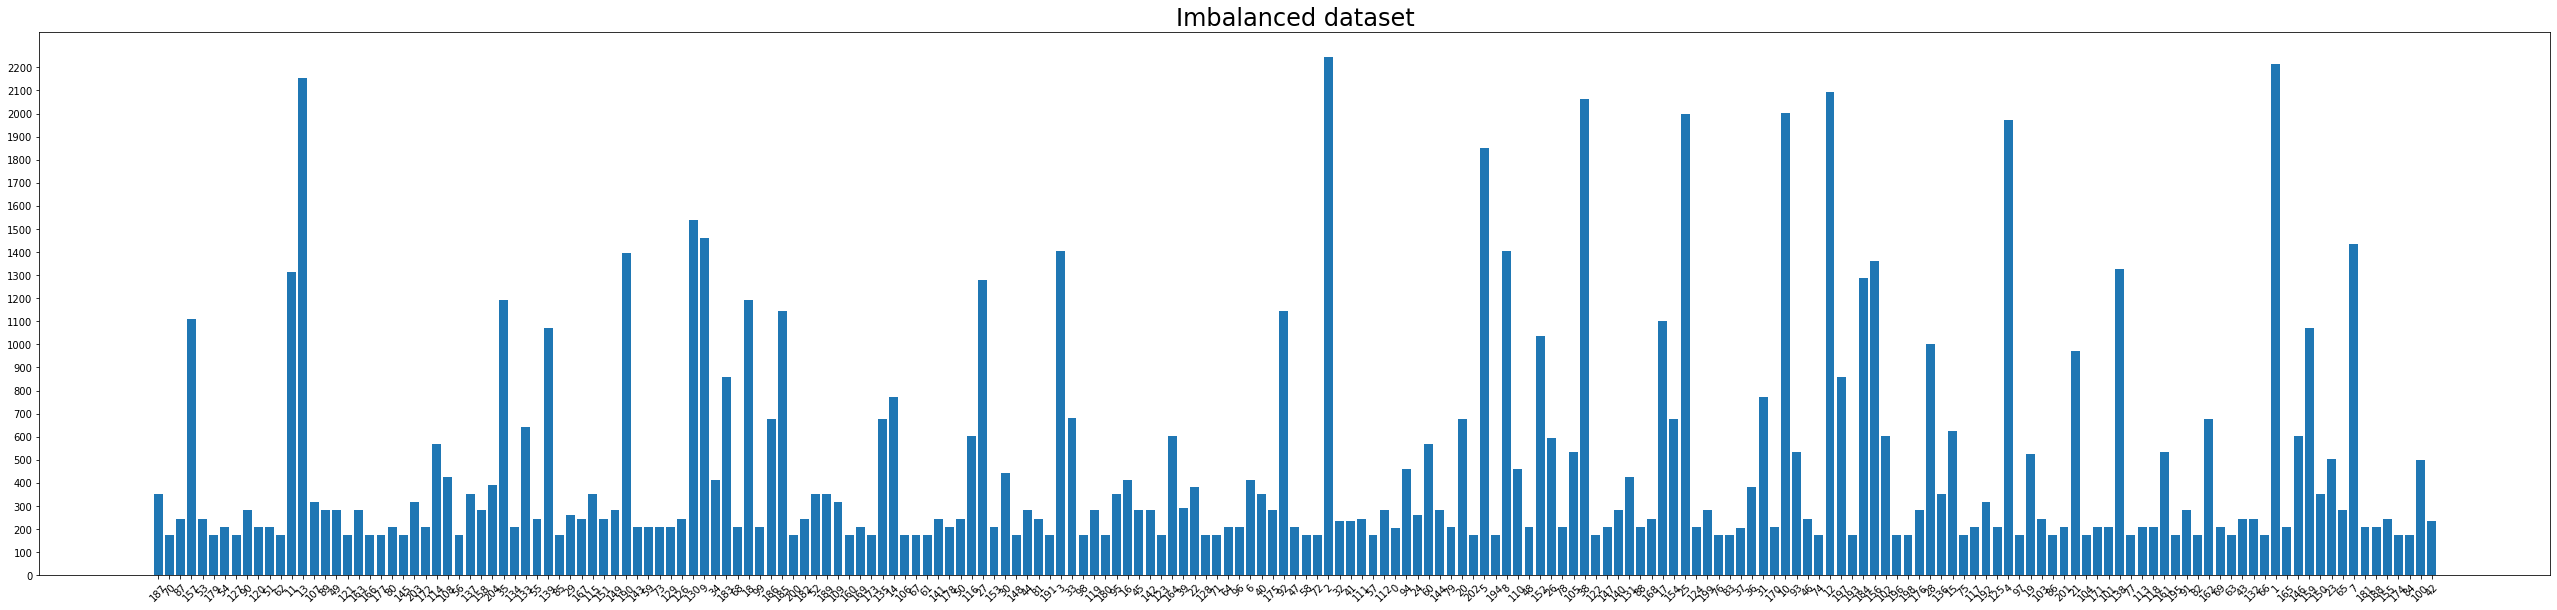

In [124]:
# balancing
def read_images(name_of_class):
  %cd /content/Data_images/Train/{name_of_class}

  folder_dir = f'/content/Data_images/Train/{name_of_class}/'
  filename_list = [file.name for file in Path(folder_dir).glob('*.png')]
  return filename_list

folder = '/content/Data_images/Train/'
subfolders = [f.name for f in Path(folder).iterdir() if f.is_dir()]

amount_of_samples = []
for i in subfolders:
  amount_of_samples.append(len(read_images(i)))

plt.figure(figsize = (45, 10))
plt.bar(subfolders , amount_of_samples)
plt.yticks(np.arange(0, max(amount_of_samples), step=100))
plt.xticks(rotation = 45)
plt.title("Imbalanced dataset", fontsize = 24)
plt.show()

In [126]:
df_before_bal = pd.read_csv("/content/Train_data.csv")

In [127]:
amount_by_classes = df_before_bal.groupby(by="ClassId").count()
amount_by_classes.min()

Unnamed: 0    173
Path          173
dtype: int64

In [ ]:
grouped = df_before_bal.groupby(by="ClassId")["Path"].apply(list)
# grouped.apply(print)
grouped


In [ ]:
import random 
k = int(amount_by_classes.min()[0])
randomed = []
for i in range(len(grouped)):
  rand_im = random.sample(list(grouped.iloc[i]), k = k )
  randomed.append(rand_im)

np.array(randomed).flatten()

In [ ]:
classes = sorted(df_before_bal["ClassId"].unique())
class_new = np.array([[classes[i]]*173 for i in classes]).flatten()
# len(class_new)

df_balanced = pd.DataFrame(data = {"ClassId": class_new, "Path":np.array(randomed).flatten()})
# df_balanced.groupby("ClassId").count().plot(kind="bar")    
# df_balanced.to_csv("Data_images/Train_balanced_data.csv")


In [139]:
# normalize transformation 
data_transforms = A.Compose([
    A.Resize(256, 256), 
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])


In [ ]:
# checking sizes

df = pd.read_csv("/content/Train_balanced_data.csv")

In [ ]:
shapes = []
for i in df["Path"]:
  image = cv2.imread(f'Data_images/{i}', cv2.IMREAD_COLOR)[:, :, ::-1]
  shapes.append(image.shape[:-1])
df["Shapes"] = shapes


In [123]:
# df["Shapes"].value_counts().head(20)
df.drop("Shape_list", axis=1, inplace=True)
shape_amount = df.groupby("Shapes").count()
shape_amount.sort_values(by="Path", ascending = False).head(20)


,Unnamed: 0,ClassId,Path
Shapes,,,
"(30, 30)",74,74,74
"(33, 33)",72,72,72
"(31, 31)",71,71,71
"(29, 29)",70,70,70
"(38, 38)",66,66,66
"(33, 32)",66,66,66
"(32, 32)",65,65,65
"(118, 121)",61,61,61
"(72, 73)",58,58,58


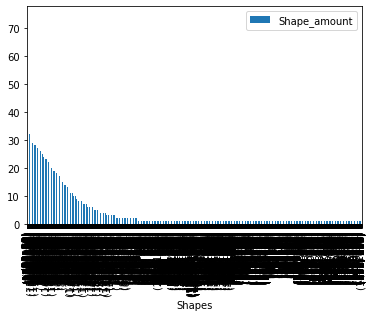

In [142]:
df_shape_amount = pd.DataFrame( {"Shape":df.groupby("Shapes")["Path"].groups.keys(), 
                                 "Shape_amount":df.groupby("Shapes")["Path"].count().sort_values(ascending = False)} )
df_shape_amount.plot(kind="bar", rot=90)


In [147]:
device = torch.device('cuda')
device=torch.device(device)

In [148]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [149]:
BATCH_SIZE = 64
learning_rate = 0.0001
EPOCHS = 5
numClasses = 205

In [143]:
class TrafficData(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        self.image_ids = df['Path'].unique()
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index, size = [112, 112]):
        image_path = self.image_ids[index]
        records = self.df[self.df['Path'] == image_path]

        #print(f'{self.image_dir}/{image_path}')
        image = cv2.imread(f'{self.image_dir}/{image_path}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        image = image.astype(float) / 255.0

        target = records['ClassId'].values

        if self.transforms:
            image = self.transforms(**image)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    @staticmethod
    def create_dataset(df, dir, transform=None):
       dataset = TrafficData(df, dir)
       return dataset

    @staticmethod 
    def loader(dataset, batch_size, num_workers=0):
       data_loader = DataLoader(
          dataset,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
#           collate_fn = collate_fn
      )
       return data_loader

In [144]:
path = Path("Data_images")


In [ ]:
df_test_messy = pd.read_csv('/content/Data_images/Test_data.csv')
df_test = pd.DataFrame(columns=['ClassId', 'Path'])

test_path = path / 'Test'
for pic in test_path.glob("*"):
    name = str(pic)[len(str(test_path)) + 1:]
    row = df_test_messy[df_test_messy['Path'] == f'Test/{name}']
    df_test = pd.concat([df_test, row])

df_test.to_csv("Test_data_cleaned.csv")
df_test.head()


,ClassId,Path
42775,111,Test/111_6_33.png
31297,114,Test/114_2_33.png
32936,164,Test/164_5_2.png
16500,201,Test/201_7_26.png
13026,27,Test/02748.png


In [ ]:
# df_train = pd.read_csv("/content/Train_data_extended.csv")
# df_test = pd.read_csv("/content/Test_data_reduced.csv")


In [ ]:
df_train_ = pd.read_csv("/content/Train_balanced_data.csv")
df_test = pd.read_csv("/content/Test_data_cleaned.csv")


In [ ]:
df_trained = df_train_.sample(frac=1).reset_index(drop=True)
# df_trained.to_csv("Train_data_balance_shuf.csv")

In [ ]:
df_train_new = pd.read_csv("Train_data_balance_shuf.csv")
df_train_new

In [ ]:
df_train = df_train_new.iloc[0:int(len(df_train_new) * 0.8), :]
df_valid = df_train_new.iloc[int(len(df_train_new) * 0.8):, :]

df_train.drop("Unnamed: 0.1", axis=1, inplace= True)
df_train.drop("Unnamed: 0", axis=1, inplace= True)

df_valid.drop("Unnamed: 0.1", axis=1, inplace= True)
df_valid.drop("Unnamed: 0", axis=1, inplace= True)


In [ ]:
train_data = TrafficData.create_dataset(df_train, path, data_transforms)
train_data_loader = TrafficData.loader(train_data, BATCH_SIZE)

test_data = TrafficData.create_dataset(df_test, path, data_transforms)
test_data_loader = TrafficData.loader(test_data, BATCH_SIZE)

valid_data = TrafficData.create_dataset(df_valid, path, data_transforms)
valid_data_loader = TrafficData.loader(valid_data, BATCH_SIZE)

In [ ]:
images, targets = next(iter(test_data_loader))


In [ ]:
for X, y in test_data_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 112, 112, 3])
Shape of y: torch.Size([64, 1]) torch.int64


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
eff_net_b0 = models.efficientnet_b0(pretrained=True)

class Eff_net(nn.Module):
    def __init__(self, pretrained_model):
        super(Eff_net,self).__init__()
        self.Eff_net = pretrained_model
        #num_inputs = pretrained_model.classifier[1].in_features
        self.fl1 = nn.Linear(1000, 256)
        self.fl2 = nn.Linear(256, numClasses)
        
    def forward(self, X):
        X = self.Eff_net(X)
        X = F.relu(self.fl1(X))
        X = F.dropout(X, p=0.25)
        X = self.fl2(X)
        return X

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = Eff_net(eff_net_b0)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for (images, labels) in loader:
        images = images.permute(0,3,1,2)
        images = images.float()
        labels = torch.reshape(labels, (-1,))
        images = images.cuda()
        labels = labels.cuda()
        
        opt.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        

        loss.backward()
        
        acc = calculate_accuracy(output, labels)
        
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.permute(0,3,1,2)
            images = images.float()
            labels = torch.reshape(labels, (-1,))
            images = images.cuda()
            labels = labels.cuda()
            
            output = model(images)
            loss = criterion(output, labels)
            
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, valid_data_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")


PATH = 'model_0.pth'
torch.save(model.state_dict(), PATH)

Epoch-0: 
Training: Loss = 2.7128, Accuracy = 0.4306, Time = 279.16 seconds
Validation: Loss = 0.4884, Accuracy = 0.8669, Time = 42.66 seconds

Epoch-1: 
Training: Loss = 0.3629, Accuracy = 0.9005, Time = 262.79 seconds
Validation: Loss = 0.1179, Accuracy = 0.9638, Time = 38.32 seconds

Epoch-2: 
Training: Loss = 0.1305, Accuracy = 0.9655, Time = 245.78 seconds
Validation: Loss = 0.0554, Accuracy = 0.9834, Time = 36.60 seconds

Epoch-3: 
Training: Loss = 0.0681, Accuracy = 0.9819, Time = 244.05 seconds
Validation: Loss = 0.0362, Accuracy = 0.9886, Time = 36.76 seconds

Epoch-4: 
Training: Loss = 0.0443, Accuracy = 0.9883, Time = 243.18 seconds
Validation: Loss = 0.0304, Accuracy = 0.9918, Time = 36.24 seconds



In [ ]:
# model = Eff_net(eff_net_b0)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [ ]:
model.load_state_dict(torch.load(PATH))

test_loss, test_acc = evaluate(model, test_data_loader, optimizer, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.165 | Test Acc: 95.83%


In [ ]:
df_test.head()

,ClassId,Path
0,4,Test/03510.png
1,156,Test/156_7_20.png
2,57,Test/57_3_29.png
3,76,Test/76_7_26.png
4,15,Test/12248.png


In [ ]:
df_train.head()

In [ ]:
df_test.groupby("ClassId").count().plot(kind="bar")

In [ ]:
test_df = df_test.sample(10000, replace=False)
test_df.groupby("ClassId").count().plot(kind="bar")

In [ ]:
isin = ~df_test.isin(test_df)
isin

In [ ]:
new_train = df_test[isin].dropna()

In [ ]:
result_train = pd.concat([df_train, new_train])

In [ ]:
# result_train.shape
result_train.to_csv("Train_data_extended.csv")

In [ ]:
test_df.to_csv("Test_data_reduced.csv")

In [ ]:
test_df = pd.read_csv("/content/Test_data_reduced.csv")

In [ ]:
test_df.shape

(10000, 4)

In [ ]:
df_train_extended = pd.read_csv("/content/Train_data_extended.csv")

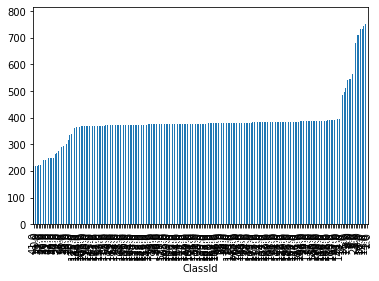

In [51]:
df_train_extended.groupby("ClassId")["Path"].count().sort_values().plot(kind="bar")

In [61]:
df_train_extended.groupby("ClassId")["Path"].count().sort_values(ascending = False)

Float64Index([ 2.0,  1.0, 13.0, 12.0, 38.0, 10.0,  4.0,  5.0,  9.0, 25.0,
              ...
              42.0, 21.0, 39.0, 20.0, 32.0, 27.0, 37.0, 19.0,  0.0, 41.0],
             dtype='float64', name='ClassId', length=205)

In [ ]:
df_train_extended_amount = pd.DataFrame( {"Class":df_train_extended.groupby("ClassId")["Path"].count().sort_values(ascending = False).keys(), 
                                 "Class_amount":df_train_extended.groupby("ClassId")["Path"].count().sort_values(ascending = False)} )
df_train_extended_amount

In [ ]:
df_train_extended_amount[df_train_extended_amount.Class_amount < 367]

In [ ]:

rotation = A.Compose([A.Rotate(45), ToTensorV2()])
flip = A.Compose([A.HorizontalFlip(p=0.5), ToTensorV2()])
perspective = A.Compose([A.Perspective(scale=[0,0.1],keep_size=False,fit_output=False,p=1), ToTensorV2()])
blur = A.Compose([A.GaussianBlur(blur_limit=(3, 7), p=0.5), ToTensorV2()])

random_transformation = [ rotation, flip, perspective, blur ]

for i in df_train_extended["Path"]:
  image = cv2.imread(f'Data_images/{i}')
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  choice = random.choice(random_transformation)
  transformed_img = choice(image=image)["image"]
  # cv2.imwrite(f'/content/Data_images/NewFolder/transformed{i}', transformed_img) 